# Exercise 05
## Unsupervised Segmentations

In this exercise, we will explore different techniques for unsupervised image segmentation. In contrast to supervised segmentation, unsupervised segmentation does **not** assign semantic labels to pixels, but rather segments images into different regions. While it does not allow for direct semantic reasoning of the image, it is still usefull to further image understanding. E.g. it allows for foreground-background segmentation of images. The main advantage of unsupervised segmentation is the absense of data labeling - still quite costly. Therefore, it allows for processing large amounts of image data.

The three methods we will be exploring in this exercise are all related to clustering data:
- k-means
- gaussian mixture models
- deep spectral clustering

We provide you with the skeleton code for all three methods and your task is to complete the implementation details as described in the three exercise parts. Each part is related to a single method.

## Imports

This will setup your whole environment such that you can work with the rest of the notebook.

### General Imports

In [1]:
from pathlib import Path

import torch
from torch.utils.data import DataLoader

### Set up directory paths and (optionally) mount in Google Colab
If you work with google colab set the `USING_COLAB` variable to `True` and following cell to mount your gdrive.

In [2]:
USING_COLAB = True
USE_CPU = False
# Use the following lines if you want to use Google Colab
# We presume you created a folder "cv3dst" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_03) is given.

if USING_COLAB:
    from google.colab import drive
    import os

    gdrive_path='/content/gdrive/MyDrive/masters/CVIII/task5/exercise_05'

    # This will mount your google drive under 'MyDrive'
    drive.mount('/content/gdrive', force_remount=True)
    # In order to access the files in this notebook we have to navigate to the correct folder
    os.chdir(gdrive_path)
    # Check manually if all files are present
    print(sorted(os.listdir()))
    root_dir = Path(gdrive_path).parent
else:
    # root_dir = Path('./cv3dst/')
    root_dir = Path('/storage/remote/adm9/cv3dst/cv3ws23/cv3_exercises/cv3dst')
dataset_dir = root_dir.joinpath("datasets")
output_dir = root_dir.joinpath('exercise_05', 'models')
output_dir.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda') if torch.cuda.is_available() and not USE_CPU else torch.device('cpu')

Mounted at /content/gdrive
['exercise_code', 'models', 'unsupervised_segmentation.ipynb']


### Exercise Specific Imports

In [3]:
from exercise_code.data.unsupervised_segmentation import KMeans, GaussianMixtureModels, SpectralClustering
from exercise_code import DavisDataset, visualize_davis, create_embeddings, downsample_annotations, visualize_model, evaluate_model, evaluate_spectral_clustering, PCA
from exercise_code.test import test_k_means, test_gaussian_mixture_model, test_spectral_clustering

%load_ext autoreload
%autoreload 2

## Extract Embeddings from Images

The following lines of code will extract per patch feature embeddings from the images of the Davis dataset. This will take a while so we recommend you to use this time to carefully read through and familiarize yourself with the rest of this notebook.

<div class="alert alert-info">
    <h3>Task: Create Embeddings for the Images</h3>
    <p> You only need to do this once. This is the same as for exercise 04. If you have already done this for exercise 04 you do not need to do this again. Set the variable <code>INITIAL_RUN</code> to <code>False</code>. If you have not done exercise 04, run the cell below. After running the cell below you should see image embeddings for the Davis dataset under <code>datasets/obj_seg/train/embeddings</code> and <code>datasets/obj_seg/test/embeddings</code>, respectively. After running it once, you should set the variable <code>INITIAL_RUN</code> to <code>False</code> to skip this in the subsequent runs of the code for a speedup.</p>
</div>

In [4]:
INITIAL_RUN = False
PATCH_SIZE = 16

if INITIAL_RUN:
    dino = torch.hub.load("facebookresearch/dino:main", f"dino_vits{PATCH_SIZE}")

    dino = dino.to(device)
    dino.eval()

    for split in ["train", "test"]:
        print(f"Creating embddings for the {split} split")
        create_embeddings(dataset_dir.joinpath("obj_seg", split), dino, device)
        print(f"Downsampling annotations for the {split} split")
        downsample_annotations(dataset_dir.joinpath("obj_seg", split), PATCH_SIZE)

# We will be working with DINO ... again!

In the previous exercise we have worked with DINO [1] embeddings for supervised segmentation. They have proven themselves to be powerful high-level embeddings that allow forground background segmentation with a single network layer. They can even be used to tasks such as semantic segmentation. In this exercise we will - again - rely on DINO features to provide us with strong clues about the images. If you want more details on DINO either look in the last exercise or check out the [paper](https://arxiv.org/abs/2104.14294) directly.

[1] Caron et al. "Emerging properties in self-supervised vision transformers." ICCV 2021

## Load Object Segmentation Datasets

This time the dataset works a bit differently. Instead of only have a single training and test dataset, we have split them up into their different categories (e.g. dog, bear, etc.). You can access the individual datasets by calling <code>train_datasets[category]</code> and <code>test_datasets[category]</code>, respectively.

In [5]:
train_datasets = DavisDataset(dataset_dir.joinpath("obj_seg", "train"), PATCH_SIZE).split_categories()
test_datasets = DavisDataset(dataset_dir.joinpath("obj_seg", "test"), PATCH_SIZE).split_categories()

## Visualize Dataset

tensor([-7.7973e-09, -7.0476e-09,  3.1114e-09], grad_fn=<MeanBackward1>)
tensor([1.0000, 0.5024, 0.5936], grad_fn=<MaxBackward0>)
tensor([-0.4453, -0.8735, -0.6274], grad_fn=<MinBackward0>)


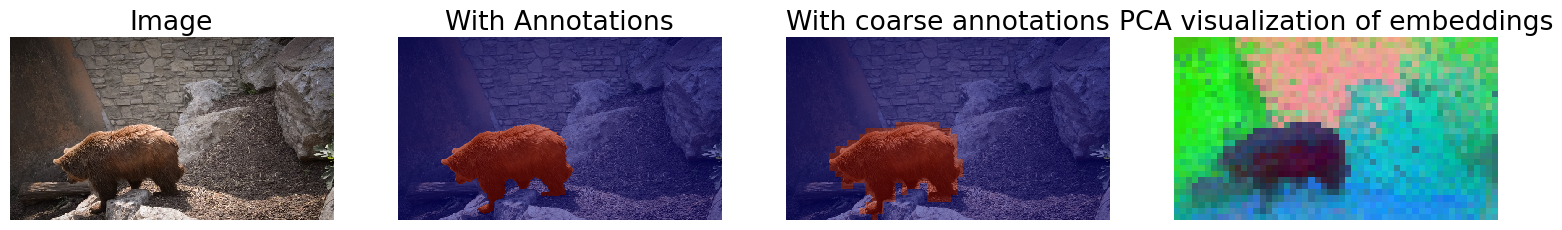

In [7]:
category = "bear"
visualize_davis(train_datasets["bear"], 50)

## Exercise Part I - K-Means Clustering

K-Means clustering is one of the easiest clustering algorithms for data. Goal of K-Means clustering is to assign each datapoint to one of the K clusters based on a distance metric to the cluster centroid. More formally, K-Means clustering tries to find to location of the cluster centroids such that the following objective is minimized

$$E(\{\boldsymbol{\mu}_1, \ldots \boldsymbol{\mu}_K\}, \boldsymbol{Z}) = \sum_{i=1}^N \sum_{k=1}^K z_{ik} d(\boldsymbol{x}_i, \boldsymbol{\mu}_k)\,,$$

where $z_{ik}$ is a binary indicator that datapoint $\boldsymbol{x}_i$ belongs to cluster $k$. $d(\cdot,\cdot)$ is a distance metric that is often chosen to be the euclidean distance. In the following we will only focus on the case for the euclidean distance.

The most popular way of solving the assingment problem is with Lloyd's algorithm for K-Means. It has the following steps
1. Initialize the centroids $\{\boldsymbol{\mu}_1, \ldots \boldsymbol{\mu}_K\}$
2. Update the cluster indicators $z_{ik}$
3. Update the centroids
4. Repeat steps 2 and 3 until convergence

Convergence can be easily checked by looking at the cluster indicators. If they didn't change since the last iteration K-Means has converged. For steps 2 and 3 we have to solve small optimization problems respectively.

For step 2 this is
$$\min_{\boldsymbol{Z}} E(\{\boldsymbol{\mu}_1, \ldots \boldsymbol{\mu}_K\}, \boldsymbol{Z})$$
which can be solved by
$$z_{ik} = \begin{cases}1 & \text{if } k=\arg\min_j \|\boldsymbol{x}_i - \boldsymbol{\mu}_j\|^2 \\ 0 & \text{else.} \end{cases}$$

For step 3 this is
$$\boldsymbol{\mu}_k = \frac{1}{N_k} \sum_{i=1}^N z_{ik} \boldsymbol{x}_i, \quad \text{where } N_k = \sum_{i=1}^N z_{ik}$$

The last open point is how to initialize the centroids. While it is possible to randomly initialize them, this is usually not the best idea. For this exercise we chose the K-Means++ initialization. The steps of K-Means++ are the following
1. Choose the first centroid $\boldsymbol{\mu}_1$, by sampling from the datapoints uniformly.
2. Compute the minimum distance of all datapoints to the previously chosen centroids $D_i^2 = \min\{\|\boldsymbol{x}_i - \boldsymbol{\mu}_1\|^2, \ldots, \|\boldsymbol{x}_i - \boldsymbol{\mu}_k\|^2\}$
3. Chose the next centroid by categorical sampling of the datapoints based on $D_i^2$
4. Repeat steps 2 and 3 until K centroids are chosen.

<div class="alert alert-info">
    <h3>Task: K-Means Clustering</h3>
    <p>
    Go to <code>exercise_code/data/unsupervised_segmentation/k_means.py</code> and implement Lloyd's algorithm for k-means clustering with the kmeans++ initialization strategy. This task is comprised of completing four methods of the <code>KMeans</code> class.
    <ul>
        <li><code>initialization</code></li>
        <li><code>distance_to_centroids</code></li>
        <li><code>assign_cluster</code></li>
        <li><code>calculate_centroids</code></li>
    </ul>
    </p>
</div>

<div class="alert alert-danger">
    <h3>Test: K-Means Clustering</h3>
    <p> Run the following cell to execute the test case for the KMeans Clustering. The test checks the implementations of each of the methods you are supposed to complete. As always the test are done with small dummy examples and no <b>not</b> guarantee correct implementation.</p>
</div>

In [8]:
_ = test_k_means()

Congratulations: The initialization function returns the correct shape.
Congratulations: The initializations are found in the data.
Method initialization() correctly implemented. Tests passed: 2/2
Congratulations: The output is correct
Congratulations: The distance to the center function returns the correct distance.
Method distance_to_centers() correctly implemented. Tests passed: 2/2
Congratulations: The output shape of assing_cluster is correct.
Congratulations: The output of assing_cluster is correct.
Method assign_clusters() correctly implemented. Tests passed: 2/2
Congratulations: The output shape of calculate_centroids is correct.
Congratulations: The output of calculate_centroids is correct.
Method calculate_centroids() correctly implemented. Tests passed: 2/2
Class KMeans correctly implemented. Tests passed: 8/8
Score: 100/100


If the previous test ran successfully you can now train a linear probing network on pretrained DINO patch embeddings to produce coarse object segmentation masks.

In [9]:
category = "bear"

dataloaders = {
    "train": DataLoader(train_datasets[category], batch_size=len(train_datasets[category]), drop_last=True),
    "test": DataLoader(test_datasets[category], batch_size=len(test_datasets[category]), drop_last=False),
}

data = next(iter(dataloaders["test"]))

pca_dims = 10
pca = PCA(pca_dims, True, data["feature_map"].flatten(0, 2))

In [10]:
num_clusters = 5
max_iter = 200
kmeans = KMeans(num_clusters=num_clusters, max_iter=max_iter)
kmeans.train(pca.do_pca(data["feature_map"].flatten(0, 2)))
evaluate_model(dataloaders["test"], kmeans, pca)

      Epoch 10 Loss: 0.5044375061988831
      Epoch 20 Loss: 0.5044422745704651
Split   Acc  Prcn  Rcll   IOU
 test  0.97  0.84  0.93  0.79


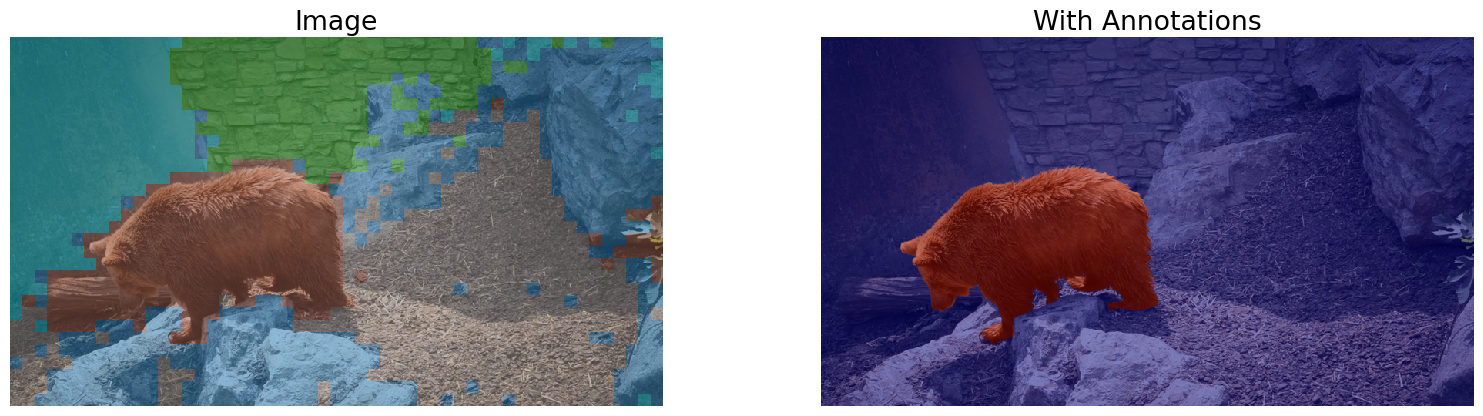

In [11]:
idx = 1
img = data["image"][idx]
feature_map = pca.do_pca(data["feature_map"][idx])
annotations = data["annotations"][idx]
assignments = kmeans.inference(feature_map.flatten(0, 1)).reshape(feature_map.shape[:2])
visualize_model(img, assignments, annotations)

## Gaussian Mixture Models

K-Means clustering is limited in its modeling capacity. It can be seen as modeling the data distribution with euqally important anisotropic gaussian distributions. However, most data does not follow this assumption. One model that lifts these assumptions is the Gaussian Mixture Model. Here, the assumption is that the data distribution follow $K$ gaussian multivariate clusters that have their of mean $\boldsymbol{\mu}_k$ and covariance $\boldsymbol{\Sigma}_k$ and a also a prior probability $\pi_k$. This allows us to model the probability of a given datapoint beloning to $\boldsymbol{x}_i$ to a cluster $k$ by computing

$$p(z_{ik} = 1) = \frac{\pi_k \mathcal{N}(\boldsymbol{x}_i | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(\boldsymbol{x}_i | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}\,,$$

also denoted as the reponsibility.

The goal is to find the cluster centers (mean) and the covariances to maximize the probability that the model fits the data distribution. This is done via the EM-algorithm that consitst of the E step and the M step.

**E-Step**: Evaluate the responsibilities with the given parameters.

$$p(z_{ik} = 1) = \frac{\pi_k^{(t)} \mathcal{N}(\boldsymbol{x}_i | \boldsymbol{\mu}_k^{(t)}, \boldsymbol{\Sigma}_k^{(t)})}{\sum_{j=1}^K \pi_j^{(t)} \mathcal{N}(\boldsymbol{x}_i | \boldsymbol{\mu}_j^{(t)}, \boldsymbol{\Sigma}_j^{(t)})}$$

**M-Step**: Re-calculate the parameters with the new responsibilities.

$$N_k = \sum_{i=1}^N p(z_{ik} = 1)$$
$$\boldsymbol{\mu}_k^{(t+1)} = \frac{1}{N_k} \sum_{i=1}^N p(z_{ik} = 1) \boldsymbol{x}_i$$
$$\boldsymbol{\Sigma}_k^{(t+1)} = \frac{1}{N_k} \sum_{i=1}^N p(z_{ik} = 1) (\boldsymbol{x}_i - \boldsymbol{\mu}_k^{(t+1)})(\boldsymbol{x}_i - \boldsymbol{\mu}_k^{(t+1)})^\top$$
$$\pi_k^{(t+1)} = \frac{N_k}{N}$$

These steps are repeated until the overall probability of the model has converged.

<div class="alert alert-info">
    <h3>Task: Gaussian Mixture Models</h3>
    <p> Go to <a href="../exercise_05/exercise_code/data/unsupervised_segmentation/gaussian_mixture_models.py"><code>exercise_code/data/unsupervised_segmentation/gaussian_mixture_models.py</code></a> and the complete the optimization for the Gaussian Mixture Model. This task is comprised of completing the
    <ul>
        <li><code>e_step</code></li>
        <li><code>m_step</code></li>
    </ul>
    class methods.</p>
</div>

<div class="alert alert-danger">
    <h3>Test: Gaussian Mixture Models</h3>
    <p> Run the following cell to execute the test case for the Gaussian Mixture Models. The test checks the implementations of each of the methods you are supposed to complete. As always the test are done with small dummy examples and no <b>not</b> guarantee correct implementation.</p>
</div>

In [ ]:
_ = test_gaussian_mixture_model()

If the previous test ran successfully you can now train a linear probing network on pretrained DINO patch embeddings to produce coarse object segmentation masks.

In [13]:
category = "dog"

dataloaders = {
    "train": DataLoader(train_datasets[category], batch_size=len(train_datasets[category]), drop_last=True),
    "test": DataLoader(test_datasets[category], batch_size=len(test_datasets[category]), drop_last=False),
}

data = next(iter(dataloaders["test"]))

pca_dims = 10
pca = PCA(pca_dims, True, data["feature_map"].flatten(0, 2))

In [ ]:
num_clusters = 5
max_iter = 200
kmeans = KMeans(num_clusters=num_clusters, max_iter=max_iter)
gmm = GaussianMixtureModels(num_classes=num_clusters, kmeans=kmeans, max_iter=max_iter, full_init=False)
gmm.train(pca.do_pca(data["feature_map"].flatten(0, 2)))
evaluate_model(dataloaders["test"], gmm, pca)

In [ ]:
idx = 5
img = data["image"][idx]
feature_map = pca.do_pca(data["feature_map"][idx])
annotations = data["annotations"][idx]
responsibilities = gmm.inference(feature_map.flatten(0, 1)).reshape((num_clusters,) + feature_map.shape[:2])
visualize_model(img, responsibilities.max(0).indices, annotations)

## Spectral Clustering

Spectral Clustering take a different approach to unsupervised segmentation. Spectral methods build upon spectral graph theory. More specificly, the connection between graph properties and the eigenvalues and eigenvectors of the Laplacian matrices of graphs. In spectral methods the image it treated as a weighted undirected graph $G=(V, E)$ of vertices $V$ and edges $E$. Based on the adjecency matrix $W$ of this graph, the image is segmented into different regions.

In this exercise we are taking a closer look at [deep spectral methods]((https://arxiv.org/abs/2205.07839)) [1], that combines classical approaches of spectral methods with learned feature representations from SOTA deep learning.

The image is discribed as an adjacency matrix
$$W = {w(u, v): (u,v) \in E}$$
where the entry $w(u, v)$ describes the affinity between pixels $u$ and $v$.

Classical methods would compute the affinity matrix based on spatial proximity and color values, which usually over-segments the image. Deep spectral methods additionally computes the affinity matrix based on learned image features. The final affinity matrix is given by

$$W_{\text{knn}}(u, v) = \begin{cases} 1 - \|\psi(u) - \psi(v)\|, & u \in \text{KNN}_{\psi}(v), \\ 0, & \text{otherwise}, \end{cases}$$
$$W_{\text{feat}} = \boldsymbol{f}\boldsymbol{f}^\top \odot (\boldsymbol{f}\boldsymbol{f}^\top > 0)$$
$$W = W_{\text{feat}} + \lambda W_{\text{knn}}$$

The image features are given by $\psi(u) = (\cos(c_H(u)), \sin(c_H(u)), c_S(u), c_V(u), p_x(u), p_y(u))$ calculated from the HSV color space $(c_H, c_S, c_V)$ and th spatial positions $(p_x, p_y)$. The deep features are given by $\boldsymbol{f}$.

From this adjacency matrix, the Laplacian is given as $L = D - W$ with $D$ is a diagonal matrix of the row-wise sum of $W$. With the Laplacian we can do object detection and even semantic segmentation. In this exercise we focus on foreground-background segmentation. For this, we take the second largest eigenvector of $L$ which we can easily threshold to produce a binary segmentation.

For computational reasons and as deep image features usually come at a lower resolution, deep spectral clustering also is computed at a lower resolution. For more infos see [1].

[1] [Melas-Kyriazi et al., Deep Spectral Methods: A Surprisingly Strong Baseline for Unsupervised Semantic Segmentation and Localization, CVPR 2022](https://arxiv.org/abs/2205.07839)

<div class="alert alert-info">
    <h3>Task: Spectral Clustering</h3>
    <p> Go to <a href="../exercise_05/exercise_code/data/unsupervised_segmentation/spectral_clustering.py"><code>exercise_code/data/unsupervised_segmentation/spectral_clustering.py</code></a> and calculate affinity matrices based on Dino features and rbg images. This task is comprised of completing the
    <ul>
        <li><code>calc_W_knn</code></li>
        <li><code>calc_W_feat</code></li>
    </ul>
    functions.</p>
</div>

<div class="alert alert-danger">
    <h3>Test: Spectral Clustering</h3>
    <p> Run the following cell to execute the test case for the Spectral Clustering. As always the test are done with small dummy examples and no <b>not</b> guarantee correct implementation.</p>
</div>

In [ ]:
_ = test_spectral_clustering()

In [ ]:
category = "dog"

dataloaders = {
    "train": DataLoader(train_datasets[category], batch_size=len(train_datasets[category]), drop_last=True),
    "test": DataLoader(test_datasets[category], batch_size=len(test_datasets[category]), drop_last=False),
}

data = next(iter(dataloaders["test"]))

In [ ]:
spectral_clustering = SpectralClustering(scaling=16, max_clusters=2, max_eigenvecs=100_000)

In [ ]:
evaluate_spectral_clustering(dataloaders["train"], spectral_clustering)

In [ ]:
idx = 5
clustering = spectral_clustering.original_cluster(data["image"][idx], data["feature_map"][idx], image_color_lambda=1.0)
visualize_model(data["image"][idx], clustering, data["annotations"][idx])

# Exercise submission

In [ ]:
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise05')